In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import io, re, sys

import numpy as np
import webdataset as wds
from lxml import html
from matplotlib import pylab
from bbox import Bbox
import iautils
import textcheck

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import imageio.v2 as imageio

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import time
import scipy.ndimage as ndi

In [3]:
def shuffled(l):
    l = list(l)
    np.random.shuffle(l)
    return l


def checkvalid(image, text):
    assert image.ndim in [2, 3]
    if image.ndim == 3:
        assert image.shape[2] == 3
    if len(text) < 1:
        return False
    h, w = image.shape[:2]
    if h < 8 or w < 8:
        return False
    return True

In [4]:
def get_text(node):
    """Extract text from a DOM node."""
    textnodes = node.xpath(".//text()")
    s = "".join([text for text in textnodes])
    return re.sub(r"\s+", " ", s)


def get_prop(node, name):
    """Get property from hOCR node."""
    title = node.get("title")
    props = title.split(";")
    for prop in props:
        (key, args) = prop.split(None, 1)
        args = args.strip('"')
        if key == name:
            return args
    return None


def get_bbox(node):
    x0, y0, x1, y1 = [int(x) for x in get_prop(node, "bbox").split()]
    return Bbox(l=x0, t=y0, r=x1, b=y1)

In [5]:
ds = wds.WebDataset("ia1-000000.tar").decode("rgb")
sample = next(iter(ds))
sample.keys()

dict_keys(['__key__', '__url__', 'hocr', 'jpg'])

In [6]:
def hocr2pages(hocr, unicodedammit=True):
    unicodedammit = True
    if unicodedammit:
        from bs4 import UnicodeDammit

        doc = UnicodeDammit(hocr, is_html=True)
        parser = html.HTMLParser(encoding=doc.original_encoding)
        doc = html.document_fromstring(hocr, parser=parser)
    elif isinstance(hocr, bytes):
        doc = html.parse(io.BytesIO(hocr))
    else:
        doc = html.parse(io.StringIO(hocr))

    pages = list(doc.xpath('//*[@class="ocr_page"]'))

    opages = []
    for i in range(len(pages)):
        page = pages[i]
        opage = dict()
        bbox = get_bbox(page)
        opage["pageno"] = i
        opage = dict(size=dict(w=bbox.width(), h=bbox.height()), lines=[], words=[])
        for line in page.xpath(".//*[@class='ocr_line']"):
            bbox = get_bbox(line)
            text = get_text(line)
            opage["lines"].append(bbox.dict(text=text))
            for word in line.xpath(".//*[@class='ocrx_word']"):
                bbox = get_bbox(word)
                text = get_text(word)
                opage["words"].append(bbox.dict(text=text))
        opages.append(opage)

    return opages

In [7]:
def scale_page_(page, scale):
    page["size"]["w"] = int(page["size"]["w"] * scale)
    page["size"]["h"] = int(page["size"]["h"] * scale)
    for w in page["words"]:
        w["t"] = int(w["t"] * scale)
        w["l"] = int(w["l"] * scale)
        w["b"] = int(w["b"] * scale)
        w["r"] = int(w["r"] * scale)
    for l in page["lines"]:
        l["t"] = int(l["t"] * scale)
        l["l"] = int(l["l"] * scale)
        l["b"] = int(l["b"] * scale)
        l["r"] = int(l["r"] * scale)

In [8]:
last_display = 0


def report(pagesample=None, wordsample=None, linesample=None, every=15, title=""):
    global last_display
    import matplotlib.pyplot as plt
    from IPython import display

    if time.time() - last_display < every:
        return
    last_display = time.time()
    plt.close("all")
    fig = plt.figure(figsize=(12, 12))
    fig.clf()
    for i in range(4):
        fig.add_subplot(2, 2, i + 1)
    ax1, ax2, ax3, ax4 = fig.get_axes()
    if pagesample:
        ax1.imshow(pagesample["jpg"], cmap="gray")
        ax1.set_title(title)
        if len(pagesample["mp"]["words"]) > 0:
            for w in pagesample["mp"]["words"]:
                iautils.Bbox(from_dict=w).draw_rect("red", ax=ax1)
        else:
            for w in pagesample["mp"]["lines"]:
                iautils.Bbox(from_dict=w).draw_rect("green", ax=ax1)
        ax2.set_title(
            f"{len(pagesample['mp']['words'])} words, {len(pagesample['mp']['lines'])} lines"
        )
        ax2.imshow(pagesample["lines.jpg"])
    if wordsample:
        ax3.imshow(wordsample["jpg"], cmap="gray")
        ax3.set_title(wordsample["txt"])
    if linesample:
        ax4.imshow(linesample["jpg"], cmap="gray")
        ax4.set_title(linesample["txt"])
    display.clear_output(wait=True)
    display.display(fig)

In [9]:
def extract_pages(
    pages,
    images,
    segwriter,
    wordwriter,
    linewriter,
    key=None,
    pagesel=None,
    wordsel=None,
    linesel=None,
    do_report=False,
):
    assert isinstance(images, list)
    if len(images) != len(pages):
        return False

    npages, nwords, nlines = 0, 0, 0
    page_offset = 0

    print(f"pages={len(pages)}:", end=" ", flush=True)

    allpages = set(range(len(pages)))
    if pagesel is not None:
        allpages = sorted(list(set(pagesel(allpages))))

    for pageno in allpages:
        print(f"{pageno} ", end="", flush=True)
        page = pages[pageno]
        page["pageno"] = pageno
        if len(page["lines"]) == 0:
            continue
        image = images[pageno + page_offset]
        h = page["size"]["h"]
        w = page["size"]["w"]
        if not (h == image.shape[0] and w == image.shape[1]):
            print("mismatch", pageno, (h, w), image.shape)
            # continue
        line_mask = iautils.make_page_mask(page, page["lines"])
        word_mask = iautils.make_page_mask(page, page["words"])

        scale = 3500.0 / max(image.shape[0], image.shape[1])
        if scale < 1.0:
            image = ndi.zoom(image, (scale, scale, 1)[: image.ndim], order=1)
            line_mask = ndi.zoom(line_mask, scale, order=0)
            word_mask = ndi.zoom(word_mask, scale, order=0)
            scale_page_(page, scale)
            page["scale"] = scale

        seg = {
            "__key__": f"{key}({pageno:04d})",
            "jpg": image,
            "lines.jpg": line_mask,
            "words.jpg": word_mask,
            "mp": page,
        }
        segwriter.write(seg)
        npages += 1
        the_linesample = None
        for lineno, line in enumerate(page["lines"]):
            bbox = iautils.Bbox(from_dict=line)
            growth = 10  # max(10, bbox.height() // 10)
            lineimage = bbox.grow(growth).extract(image)
            linetext = line["text"]
            if not checkvalid(lineimage, linetext) or lineimage.shape[0] > 100:
                continue
            if linesel is not None and not linesel(lineno, linetext, lineimage):
                continue
            linesample = {
                "__key__": f"{key}({pageno:04d}-{lineno:04d})",
                "jpg": lineimage,
                "txt": linetext,
            }
            if lineno < 10:
                the_linesample = linesample
            linewriter.write(linesample)
            nlines += 1
        the_wordsample = None
        for wordno, word in enumerate(page["words"]):
            bbox = iautils.Bbox(from_dict=word)
            growth = 10  # max(10, bbox.height() // 10)
            wordimage = bbox.grow(growth).extract(image)
            wordtext = word["text"]
            if not checkvalid(wordimage, wordtext) or wordimage.shape[0] > 100:
                continue
            if wordsel is not None and not wordsel(wordno, wordtext, wordimage):
                continue
            wordsample = {
                "__key__": f"{key}({pageno:04d}-{wordno:04d})",
                "jpg": wordimage,
                "txt": wordtext,
            }
            if wordno < 20:
                the_wordsample = wordsample
            wordwriter.write(wordsample)
            nwords += 1
        if do_report:
            report(
                pagesample=seg,
                wordsample=the_wordsample,
                linesample=the_linesample,
                title=f"{key}({pageno:04d})",
            )
    print()
    return npages, nwords, nlines

In [10]:
class Nothing(Exception):
    pass

In [11]:
def convert_hocr1_shard(
    url,
    prefix="",
    maxbooks=99999999,
    linesel=None,
    wordsel=None,
    exn=Nothing,
    do_report=False,
):
    ds = wds.WebDataset(url).decode("rgb")
    segwriter = wds.TarWriter(prefix + "segs.tar")
    wordwriter = wds.TarWriter(prefix + "words.tar")
    linewriter = wds.TarWriter(prefix + "lines.tar")
    nbooks = 0
    try:
        for sample in ds:
            try:
                pages = hocr2pages(sample["hocr"])
                assert len(pages) == 1
            except exn as e:
                print("failed to parse hocr", repr(e))
                continue
            try:
                image = sample["jpg"]
                result = extract_pages(
                    pages,
                    [image],
                    segwriter,
                    wordwriter,
                    linewriter,
                    key=sample["__key__"],
                    do_report=do_report,
                )
                if result is False:
                    print("failed", sample["__key__"])
                else:
                    npages, nwords, nlines = result
                    print(
                        f"{prefix} {sample['__key__']} {npages} pages, {nwords} words, {nlines} lines"
                    )
                    nbooks += 1
            except exn as e:
                print("failed to parse hocr", repr(e))
                continue
    finally:
        segwriter.close()
        wordwriter.close()
        linewriter.close()

In [12]:
@interact_manual
def run_test(url="ia1-000000.tar", prefix="ia1-000000-"):
    convert_hocr1_shard(url, prefix, do_report=True)

interactive(children=(Text(value='ia1-000000.tar', continuous_update=False, description='url'), Text(value='ia…

In [13]:
def run(cmd):
    print("#", cmd)
    assert 0 == os.system(cmd), f"command failed: {cmd}"

def gsexists(src):
    if src.startswith("gs://"):
        return os.system(f"gsutil ls '{src}' > /dev/null 2>&1") == 0
    else:
        return os.path.exists(src)

def gscopy(src, dst, remove=False):
    if src.startswith("gs://") or dst.startswith("gs://"):
        if src.startswith("gs://"):
            assert not remove
        run(f"gsutil cp '{src}' '{dst}'")
    else:
        run(f"cp '{src}' '{dst}'")
        if remove:
            run(f"rm '{src}'")

In [14]:
def extract_shard(src, prefix, do_report=False, env={}, npages=5):
    os.environ.update(env)
    base = src.split("/")[-1]
    root = src.split("/")[-1].split(".")[0]
    print(f"\n=== {src} ===\n")
    if gsexists(f"{prefix}/words/{root}-words.tar"):
        print(f"shard {shard} already exists")
        return "already-done"    
    if not os.path.exists(base):
        gscopy(src, base)
    convert_hocr1_shard(base, prefix=f"{root}-", wordsel=textcheck.wordsel, exn=Nothing, do_report=do_report)
    gscopy(f"{root}-words.tar", f"{prefix}/words/{root}-words.tar", remove=True)
    gscopy(f"{root}-lines.tar", f"{prefix}/lines/{root}-lines.tar", remove=True)
    gscopy(f"{root}-segs.tar", f"{prefix}/segs/{root}-segs.tar", remove=True)
    os.remove(base)
    return "finished"

In [15]:
import os
shards = os.popen("gsutil ls gs://ocro-ia1/tess/*.tar").read().split()
shards

['gs://ocro-ia1/tess/ia1-000000.tar',
 'gs://ocro-ia1/tess/ia1-000001.tar',
 'gs://ocro-ia1/tess/ia1-000002.tar',
 'gs://ocro-ia1/tess/ia1-000003.tar',
 'gs://ocro-ia1/tess/ia1-000004.tar',
 'gs://ocro-ia1/tess/ia1-000005.tar',
 'gs://ocro-ia1/tess/ia1-000006.tar',
 'gs://ocro-ia1/tess/ia1-000007.tar',
 'gs://ocro-ia1/tess/ia1-000008.tar',
 'gs://ocro-ia1/tess/ia1-000009.tar',
 'gs://ocro-ia1/tess/ia1-000010.tar',
 'gs://ocro-ia1/tess/ia1-000011.tar',
 'gs://ocro-ia1/tess/ia1-000012.tar',
 'gs://ocro-ia1/tess/ia1-000013.tar',
 'gs://ocro-ia1/tess/ia1-000014.tar',
 'gs://ocro-ia1/tess/ia1-000015.tar',
 'gs://ocro-ia1/tess/ia1-000016.tar',
 'gs://ocro-ia1/tess/ia1-000017.tar',
 'gs://ocro-ia1/tess/ia1-000018.tar',
 'gs://ocro-ia1/tess/ia1-000019.tar',
 'gs://ocro-ia1/tess/ia1-000020.tar',
 'gs://ocro-ia1/tess/ia1-000021.tar',
 'gs://ocro-ia1/tess/ia1-000022.tar',
 'gs://ocro-ia1/tess/ia1-000023.tar',
 'gs://ocro-ia1/tess/ia1-000024.tar',
 'gs://ocro-ia1/tess/ia1-000025.tar',
 'gs://ocro-

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

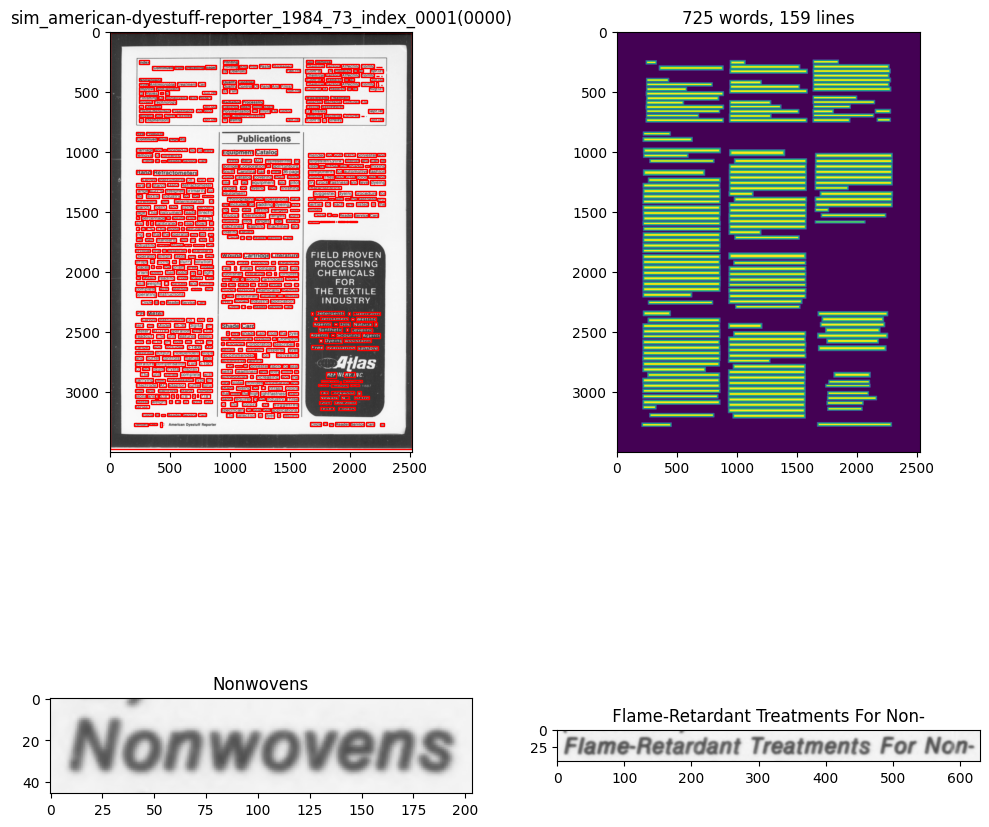

In [16]:
@interact_manual
def run_test():
    extract_shard("gs://ocro-ia1/tess/ia1-000000.tar", "gs://ocro-ia1/tess", do_report=True)

In [17]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/tmb/proj/pdfocrhelpers/venv/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [18]:
def normalize(a):
    a = a.astype("float32")
    a = a - a.min()
    a /= a.max()
    return a

In [19]:
from itertools import islice


@interact_manual
def show_segs(url="ia1-000000-segs.tar", start=10):
    start = max(start, 0)
    ds = wds.WebDataset(url).decode("rgb")
    sample = next(iter(islice(ds, start, start + 1)))
    figsize(18, 10)
    subplot(131)
    imshow(sample["jpg"])
    subplot(132)
    imshow(normalize(sample["lines.jpg"]))
    subplot(133)
    imshow(normalize(sample["words.jpg"]))

interactive(children=(Text(value='ia1-000000-segs.tar', continuous_update=False, description='url'), IntSlider…

In [20]:
from itertools import islice


@interact_manual
def show_segs(url="ia1-000000-segs.tar", start=10, x=1500, y=1500, r=256):
    clf()
    sl = slice(y, y + r), slice(x, x + r)
    start = max(start, 0)
    ds = wds.WebDataset(url).decode("rgb")
    sample = next(iter(islice(ds, start, start + 1)))
    figsize(18, 10)
    try:
        subplot(131)
        imshow(sample["jpg"][sl])
        subplot(132)
        imshow(normalize(sample["lines.jpg"][sl]))
        subplot(133)
        imshow(normalize(sample["words.jpg"][sl]))
    except:
        pass

interactive(children=(Text(value='ia1-000000-segs.tar', continuous_update=False, description='url'), IntSlider…